In [2]:
import wooldridge as woo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# By Zepeng Wang,Chenrui Wang, Changhe Xie

# Introduction:
## We want to figure out whether the economics course performance of one student has relationship with his or her math ability and which measures of math-related variables can be an indicator to predict the student's economics coure scores.
## The data are from wooldridge package's econmath dataset.

##### A data.frame with 856 observations on 17 variables:
#### age: age in years

#### work: hours worked per week

#### study: hours studying per week

#### econhs: =1 if economics in high school

#### colgpa: college GPA, beginning semester

#### hsgpa: high school GPA

#### acteng: ACT English score

#### actmth: ACT math score

#### act: ACT composite

#### mathscr: math quiz score, 0-10

#### male: =1 if male

#### calculus: =1 if taken calculus course

#### attexc: =1 if past attndce 'excellent'

#### attgood: =1 if past attndce 'good'

#### fathcoll: =1 if father has BA

#### mothcoll: =1 if mother has BA

#### score: course score, in percent

In [3]:
econmath = woo.data("econmath")

In [4]:
econmath.head()

,age,work,study,econhs,colgpa,hsgpa,acteng,actmth,act,mathscr,male,calculus,attexc,attgood,fathcoll,mothcoll,score
0,23,15.0,10.0,0,3.4909,3.355,24.0,26.0,27.0,10,1,1,0,0,1,1,84.43
1,23,0.0,22.5,1,2.1000,3.219,23.0,20.0,24.0,9,1,0,0,0,0,1,57.38
2,21,25.0,12.0,0,3.0851,3.306,21.0,24.0,21.0,8,1,1,1,0,0,1,66.39
3,22,30.0,40.0,0,2.6805,3.977,31.0,28.0,31.0,10,0,1,0,1,1,1,81.15
4,22,25.0,15.0,1,3.7454,3.890,28.0,31.0,32.0,8,1,1,0,1,0,1,95.90


## 1. Variable Selection:
## (a) Using the Boruta Algorithm identify the top ∼5-10 quantitative predictors (could be fewer 5 depending on your finding).

### Considering BorutaShap function in Python doesn't allow the dataset to have any NAs,
### in the first step, we decide to deal with NAs, using the method of kNN.

In [21]:
print(econmath.isnull().any())
print(econmath.isnull().sum())

age         False
work        False
study       False
econhs      False
colgpa      False
hsgpa       False
acteng       True
actmth       True
act          True
mathscr     False
male        False
calculus    False
attexc      False
attgood     False
fathcoll    False
mothcoll    False
score       False
dtype: bool
age          0
work         0
study        0
econhs       0
colgpa       0
hsgpa        0
acteng      42
actmth      42
act         42
mathscr      0
male         0
calculus     0
attexc       0
attgood      0
fathcoll     0
mothcoll     0
score        0
dtype: int64


### There does exist NAs of acteng, actmth and act in the dataset!!! So we must solve this problem.

In [23]:
econmath[['acteng','actmth','act']].describe()

,acteng,actmth,act
count,814.000000,814.000000,814.000000
mean,22.594595,23.211302,23.121622
std,3.788735,3.773354,3.349094
min,12.000000,12.000000,13.000000
25%,20.000000,20.000000,21.000000
50%,23.000000,23.000000,23.000000
75%,25.000000,26.000000,25.000000
max,34.000000,36.000000,33.000000


In [4]:
import rpy2

import warnings
warnings.filterwarnings('ignore')
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import rpy2.rinterface as rinterface
pandas2ri.activate()

%load_ext rpy2.ipython

In [5]:
econmath_r = pandas2ri.py2rpy(econmath)
%R -i econmath_r

In [60]:
%%R
head(econmath_r)

  age work study econhs colgpa hsgpa acteng actmth act mathscr male calculus
0  23   15  10.0      0 3.4909 3.355     24     26  27      10    1        1
1  23    0  22.5      1 2.1000 3.219     23     20  24       9    1        0
2  21   25  12.0      0 3.0851 3.306     21     24  21       8    1        1
3  22   30  40.0      0 2.6805 3.977     31     28  31      10    0        1
4  22   25  15.0      1 3.7454 3.890     28     31  32       8    1        1
5  22    0  30.0      0 3.0555 3.500     25     30  28      10    1        1
  attexc attgood fathcoll mothcoll score
0      0       0        1        1 84.43
1      0       0        0        1 57.38
2      1       0        0        1 66.39
3      0       1        1        1 81.15
4      0       1        0        1 95.90
5      1       0        0        1 83.61


    age work study econhs colgpa hsgpa mathscr male calculus attexc attgood
814   1    1     1      1      1     1       1    1        1      1       1
42    1    1     1      1      1     1       1    1        1      1       1
      0    0     0      0      0     0       0    0        0      0       0
    fathcoll mothcoll score acteng actmth act    
814        1        1     1      1      1   1   0
42         1        1     1      0      0   0   3
           0        0     0     42     42  42 126



载入程辑包：'mice'

The following object is masked from 'package:stats':

    filter

The following objects are masked from 'package:base':

    cbind, rbind

In addition: Warning message:
In Sys.setlocale("LC_ALL", "en_US.UTF-8") :
  using locale code page other than 936 may cause problems


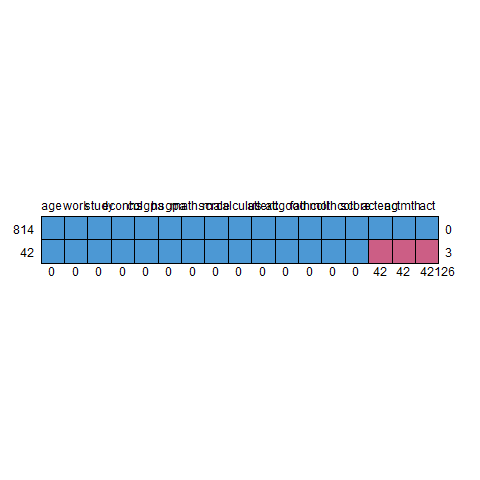

In [7]:
%%R
Sys.setlocale("LC_ALL", "en_US.UTF-8")
library(mice)
md.pattern(econmath_r)

#### 42 missing observations of three variables are from the same observations.

In [ ]:
# Method : knn imputation

In [8]:
%%R
library('DMwR')
knnOutput <- knnImputation(econmath_r)
anyNA(knnOutput) # Check that we don't have any NAs left in the entire dataset

[1] FALSE


In [325]:
knnOutput_r = robjects.r['knnOutput']
econmath_new = pandas2ri.rpy2py(knnOutput_r)
econmath_new.head()

,age,work,study,econhs,colgpa,hsgpa,acteng,actmth,act,mathscr,male,calculus,attexc,attgood,fathcoll,mothcoll,score
0,23,15.0,10.0,0,3.4909,3.355,24.0,26.0,27.0,10,1,1,0,0,1,1,84.43
1,23,0.0,22.5,1,2.1000,3.219,23.0,20.0,24.0,9,1,0,0,0,0,1,57.38
2,21,25.0,12.0,0,3.0851,3.306,21.0,24.0,21.0,8,1,1,1,0,0,1,66.39
3,22,30.0,40.0,0,2.6805,3.977,31.0,28.0,31.0,10,0,1,0,1,1,1,81.15
4,22,25.0,15.0,1,3.7454,3.890,28.0,31.0,32.0,8,1,1,0,1,0,1,95.90


In [87]:
print(econmath_new.isnull().any())
print(econmath_new.isnull().sum())

age         False
work        False
study       False
econhs      False
colgpa      False
hsgpa       False
acteng      False
actmth      False
act         False
mathscr     False
male        False
calculus    False
attexc      False
attgood     False
fathcoll    False
mothcoll    False
score       False
dtype: bool
age         0
work        0
study       0
econhs      0
colgpa      0
hsgpa       0
acteng      0
actmth      0
act         0
mathscr     0
male        0
calculus    0
attexc      0
attgood     0
fathcoll    0
mothcoll    0
score       0
dtype: int64


### OK, the NA problem has been solved! Next, we will do variable selection.

In [129]:
# Extract subsets of quantitative variables
econmath_qv = econmath_new[['score','age','work','study','colgpa','hsgpa','acteng','actmth','act','mathscr']]

In [130]:
econmath_qv.head()

,score,age,work,study,colgpa,hsgpa,acteng,actmth,act,mathscr
0,84.43,23,15.0,10.0,3.4909,3.355,24.0,26.0,27.0,10
1,57.38,23,0.0,22.5,2.1000,3.219,23.0,20.0,24.0,9
2,66.39,21,25.0,12.0,3.0851,3.306,21.0,24.0,21.0,8
3,81.15,22,30.0,40.0,2.6805,3.977,31.0,28.0,31.0,10
4,95.90,22,25.0,15.0,3.7454,3.890,28.0,31.0,32.0,8


In [134]:
econmath_new.columns = econmath_new.columns.map(str)
print(econmath_new.columns)
print([type(col) for col in econmath_new.columns])

Index(['age', 'work', 'study', 'econhs', 'colgpa', 'hsgpa', 'acteng', 'actmth',
       'act', 'mathscr', 'male', 'calculus', 'attexc', 'attgood', 'fathcoll',
       'mothcoll', 'score'],
      dtype='object')
[<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>]


In [135]:
from BorutaShap import BorutaShap
from sklearn.ensemble import RandomForestRegressor

In [136]:
y = econmath_new['score']
x = econmath_new[['age','work','study','colgpa','hsgpa','acteng','actmth','act','mathscr']]

  0%|          | 0/50 [00:00<?, ?it/s]

4 attributes confirmed important: ['mathscr', 'act', 'actmth', 'colgpa']
5 attributes confirmed unimportant: ['acteng', 'age', 'work', 'hsgpa', 'study']
0 tentative attributes remains: []


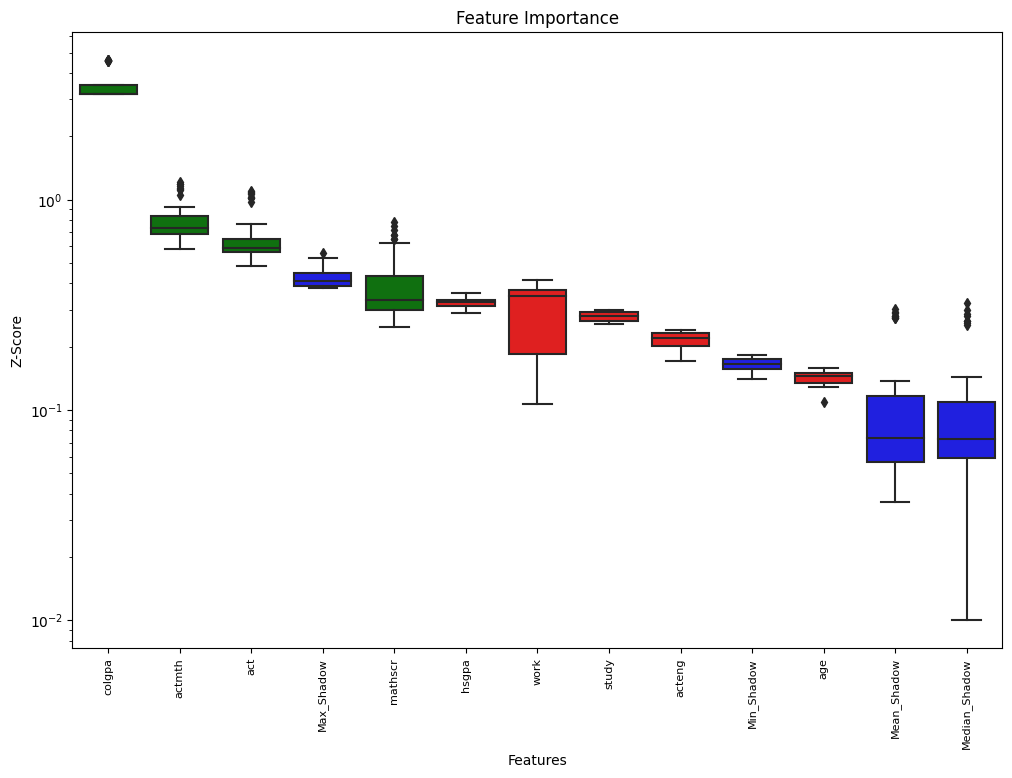

In [137]:
# 10 minutes to run for n_trial=50 
# if model is not specified in BroutaShap(): default = random forest (just like R and BorutaPy)
Feature_Selector = BorutaShap(importance_measure='shap', classification=False)
Feature_Selector.fit(X=x, y=y, n_trials=50, random_state=0)
Feature_Selector.plot(which_features='all')

## (b) Using standard techniques, identify at least 2-3 factor variables to include as predictors.The combined predictors from parts (a) and (b) are the ones you will work with going forward in the analysis for parts (2) and (3).

         Abbreviation
econhs              e
male               ml
calculus            c
attexc           attx
attgood          attg
fathcoll            f
mothcoll           mt


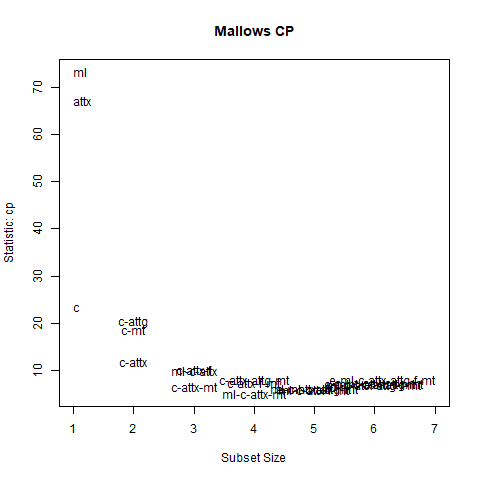

In [169]:
%%R
library(AER)
library(broom)
library(leaps)
mreg.mod5 <- lm(score~econhs+male+calculus+attexc+attgood+fathcoll+mothcoll,data=econmath)
ss=regsubsets(score~econhs+male+calculus+attexc+attgood+fathcoll+mothcoll,,method=c("exhaustive"),nbest=3,data=econmath)
subsets(ss,statistic="cp",legend=F,main="Mallows CP",col="steelblue4")

In [142]:
manova1 = smf.ols('score ~ C(econhs,Treatment(reference=0))+ C(male,Treatment(reference=0)) + \
                  C(calculus,Treatment(reference=0)) +  C(attexc,Treatment(reference=0)) + \
                   C(attgood,Treatment(reference=0)) +  C(fathcoll,Treatment(reference=0)) + \
                    C(mothcoll,Treatment(reference=0))' ,data = econmath_new).fit()
manova1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     12.37
Date:                Fri, 17 Nov 2023   Prob (F-statistic):           3.86e-15
Time:                        20:40:48   Log-Likelihood:                -3394.1
No. Observations:                 856   AIC:                             6804.
Df Residuals:                     848   BIC:                             6842.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   63.2540      1.645     38.461      0.000      60.026      66.482
C(econhs, Treatment(reference=0))[T.1]      -0.8664      0.910     -0.952      0.341      -2.653       0.920
C(male, Treatment(reference=0))[T.1]         1.7406      0.890      1.955      0.051      -0.007       3.488
C(calculus, Treatment(reference=0))[T.1]     6.7690      0.948      7.138      0.000       4.908       8.630
C(attexc, Treatment(reference=0))[T.1]       5.0475      1.524      3.311      0.001       2.056       8.039
C(attgood, Treatment(reference=0))[T.1]      1.6001      1.411      1.134      0.257      -1.170       4.370
C(fathcoll, Treatment(reference=0))[T.1]     1.0113      0.937      1.079      0.281      -0.828       2.851
C(mothcoll, Treatment(reference=0))[T.1]     1.9908      0.965      2.063      0.039       0.096       3.885
==============================================================================
Omnibus:                       58.455   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.589
Skew:                          -0.648   Prob(JB):                     7.74e-16
Kurtosis:                       3.523   Cond. No.                         9.67
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Calculus + attexc + mothcoll +male are our indicator variable choice.

## 2. Descriptive Analysis

### 2-a

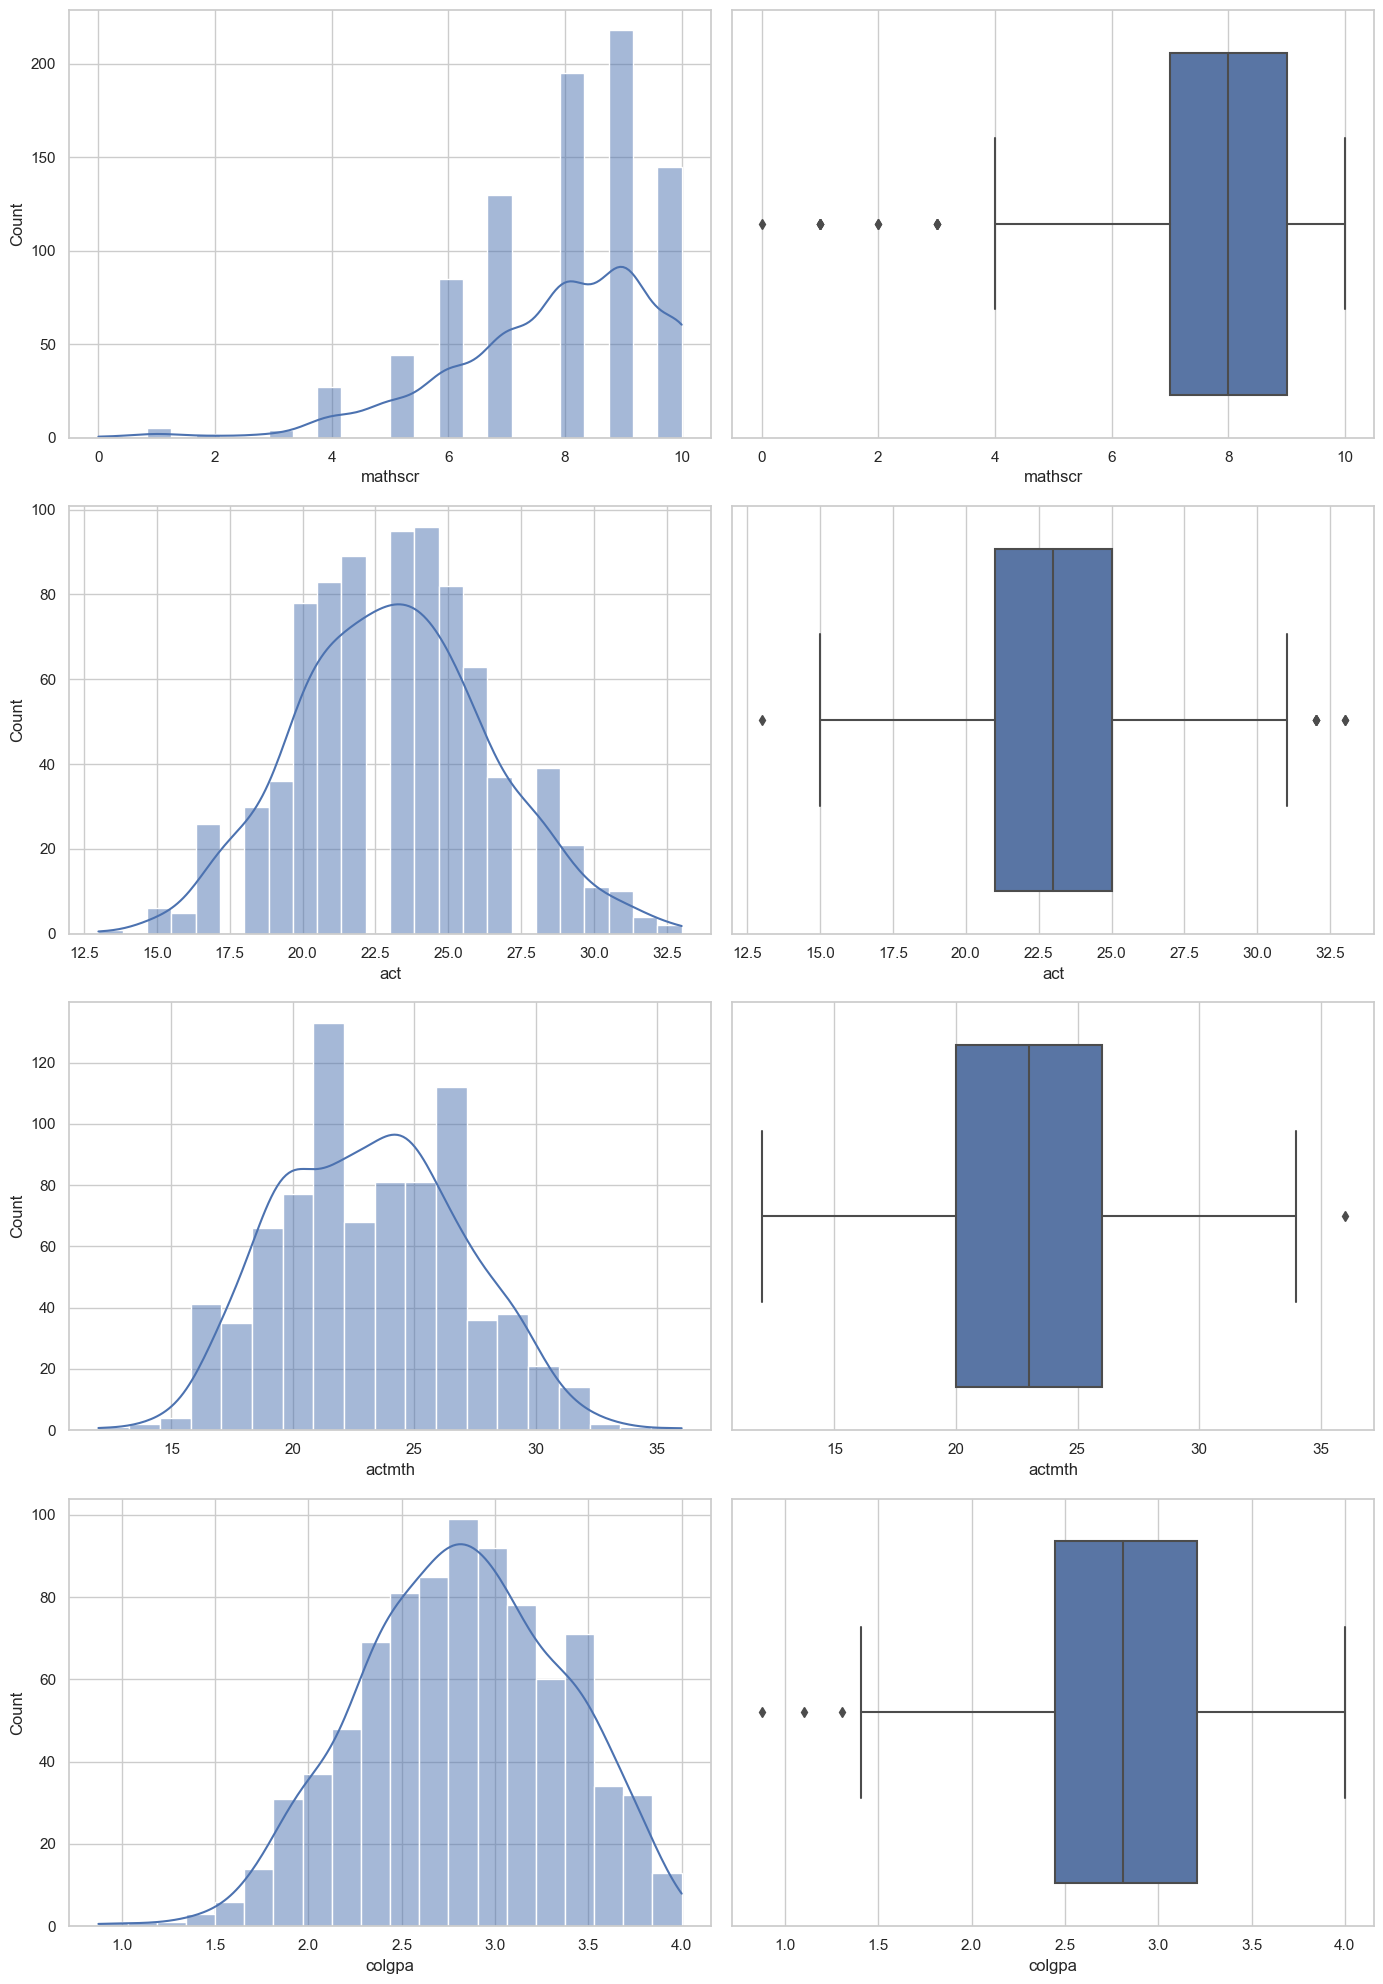

In [312]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
quant_vars = ['mathscr', 'act', 'actmth', 'colgpa']
fig, axes = plt.subplots(4, 2, figsize=(14, 20))
for i, var in enumerate(quant_vars):
    sns.histplot(econmath[var], kde=True, ax=axes[i, 0])
    sns.boxplot(x=econmath[var], ax=axes[i, 1])
plt.tight_layout()
plt.show()

#### In the study analyzing students' academic performance,various statistical tools were employed to gain a deeper understanding of student performance in areas such as math test scores (mathscr), ACT composite scores (act), ACT math scores (actmth), and college GPA (colgpa).
#### Histograms and box plots provided visual representations of the distribution of these scores, while correlation analysis revealed the interrelationships among these variables.

#### The analysis of math test scores revealed a notably right-skewed distribution, with most students performing well in this area. However, some lower outliers, as shown in the box plots, indicate that despite high scores achieved by many, a minority struggled. This distribution might reflect the impact of specific teaching methods or course difficulty on students with varying abilities.

#### For ACT composite scores, the data exhibited a more symmetric distribution, possibly indicating the balanced nature and broad applicability of the test. The corresponding box plots further showed that most students' scores were concentrated in the medium range, without significant outliers, suggesting a wide range of academic abilities.
#### The analysis of ACT math scores was similar to that of math test scores, showing a slight right skew, indicating good performance by the majority. However, some low outliers were also observed, potentially reflecting individual students' adaptability to standardized tests.

#### College GPA analysis showed a highly concentrated distribution, with most students' GPAs nearing the maximum. 
#### This distribution might reflect the characteristics of the college grading system or students' adaptation to the university learning environment.

### 2-b

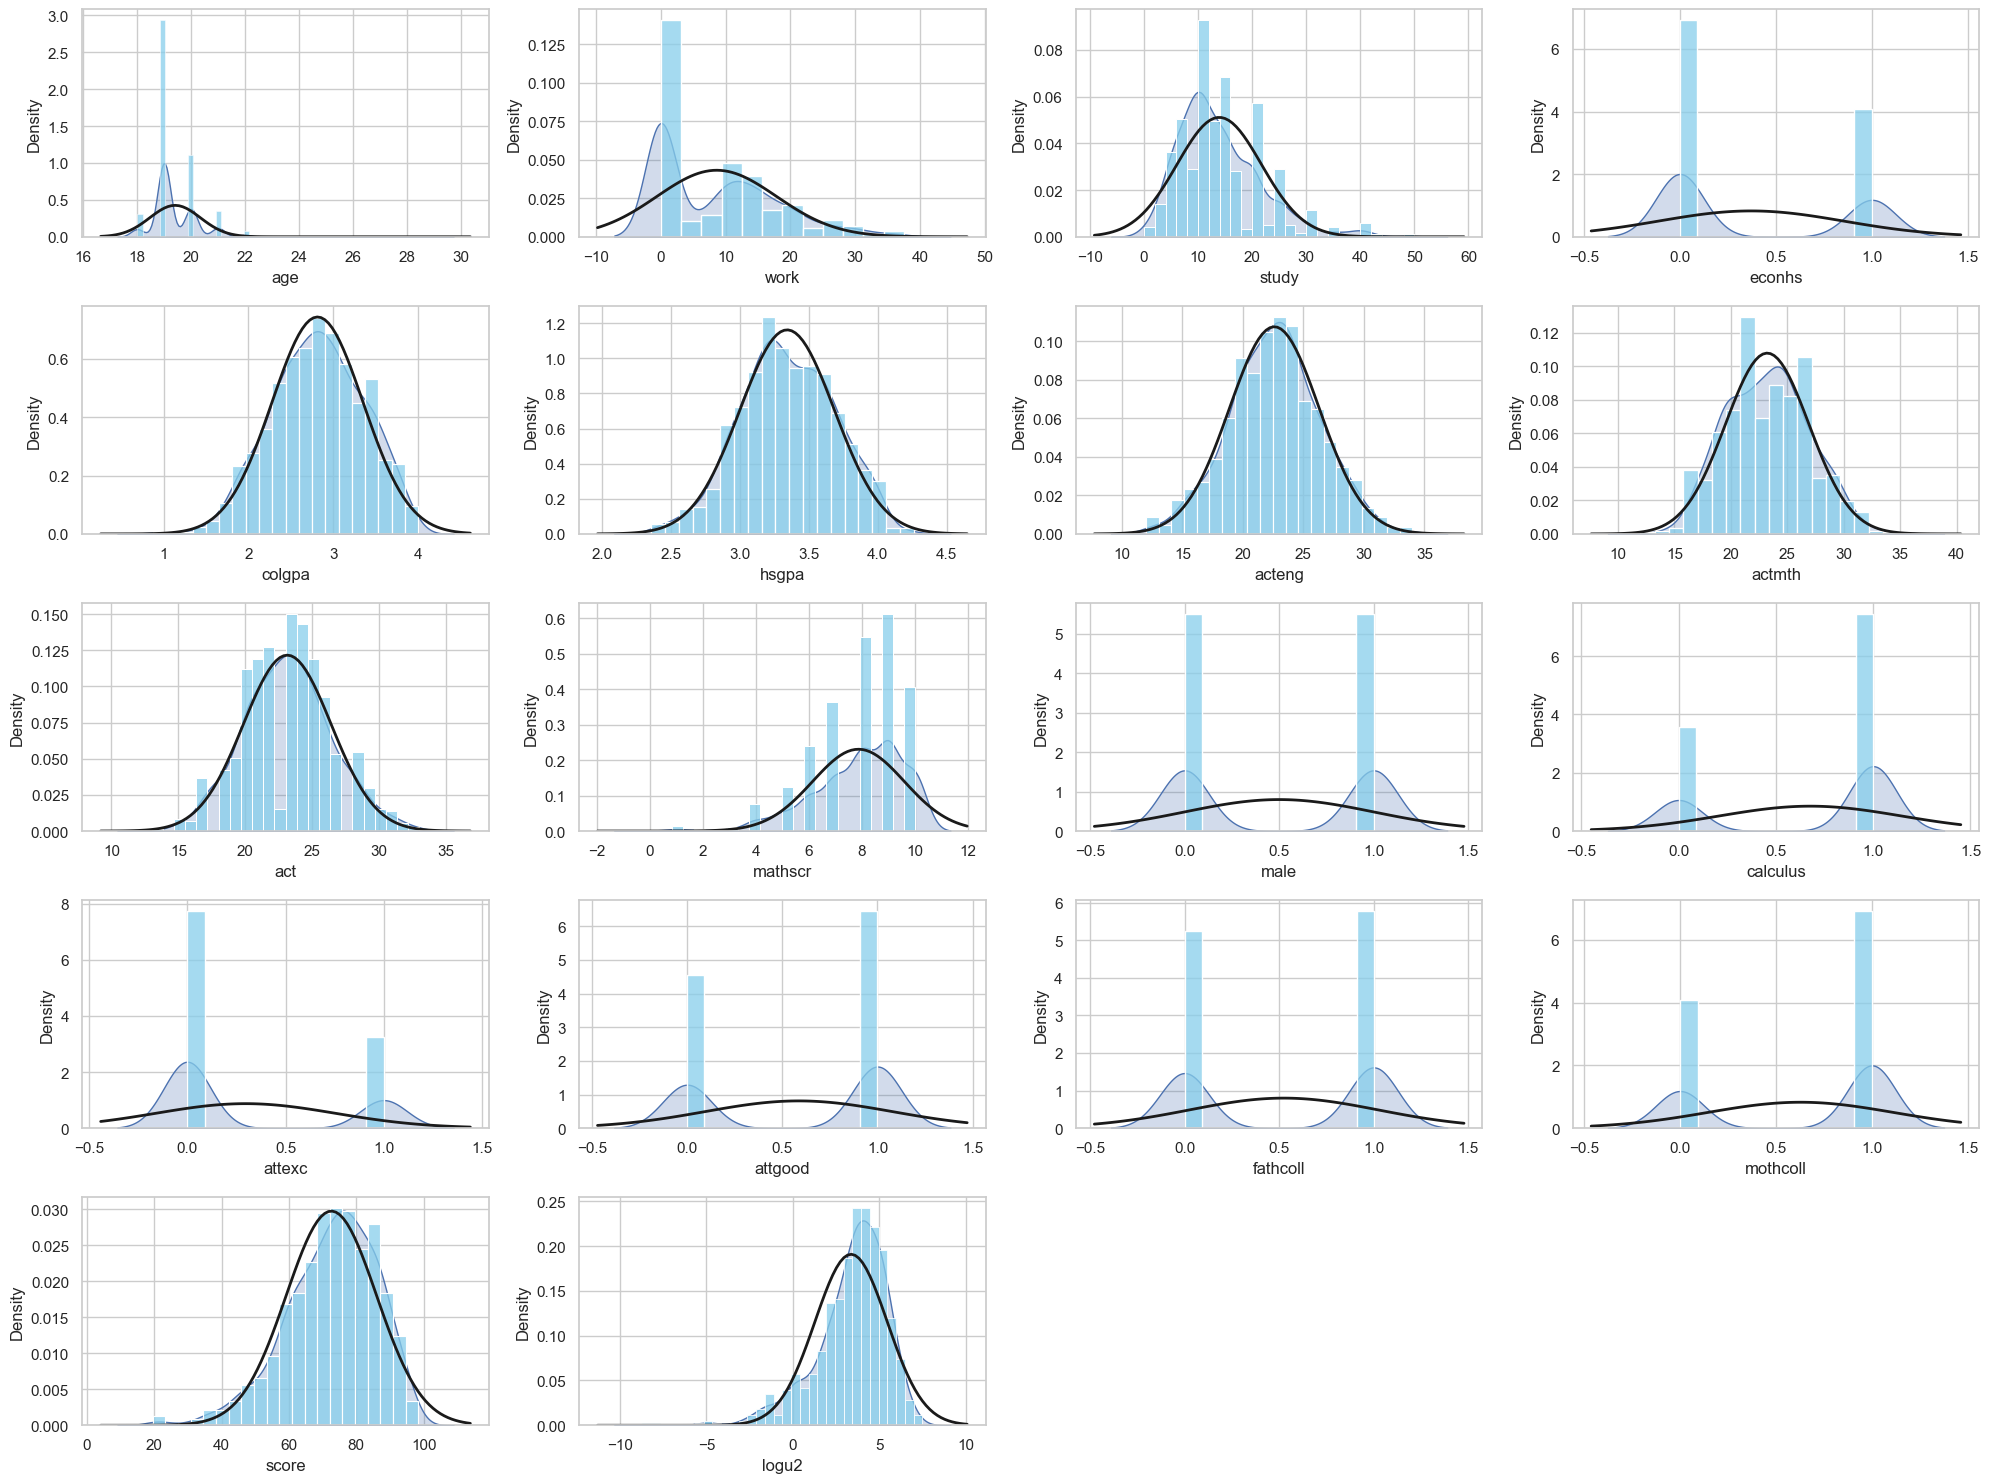

In [313]:
import numpy as np
from scipy import stats

plt.figure(figsize=(20, 15))
for i, column in enumerate(econmath_new.columns):
    plt.subplot(5, 4, i + 1)
    sns.kdeplot(econmath_new[column], fill=True)
    sns.histplot(econmath_new[column], kde=False, stat="density", color="skyblue")
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, econmath_new[column].mean(), econmath_new[column].std())
    plt.plot(x, p, 'k', linewidth=2)
plt.tight_layout()
plt.show()

#### Each chart displays a kernel density estimate (KDE) for a variable, alongside an attempted fit with a normal distribution curve.
#### The KDE visually represents the density of data at different values in a curve format.
#### The normal distribution curve shows how these data can be best approximated using a standard normal distribution model.

### Characteristics of Variable Distributions:  
#### Some variables appear close to a normal distribution, such as colgpa (college GPA), with a distribution that is relatively symmetric and concentrated around high middle values.Others, like work (weekly working hours), exhibit a clear skew, likely because most students work fewer hours.Binary variables (e.g., male, econhs) do not conform to normal distribution, as they are categorical, not continuous.

### Accuracy of Fitting:

#### For some variables, the fit with a normal distribution might not be ideal, indicating that the actual distribution may not be normal or may have more complex characteristics.
#### For continuous variables with an approximately symmetric distribution, the normal distribution fit tends to be more accurate.

### 2-c

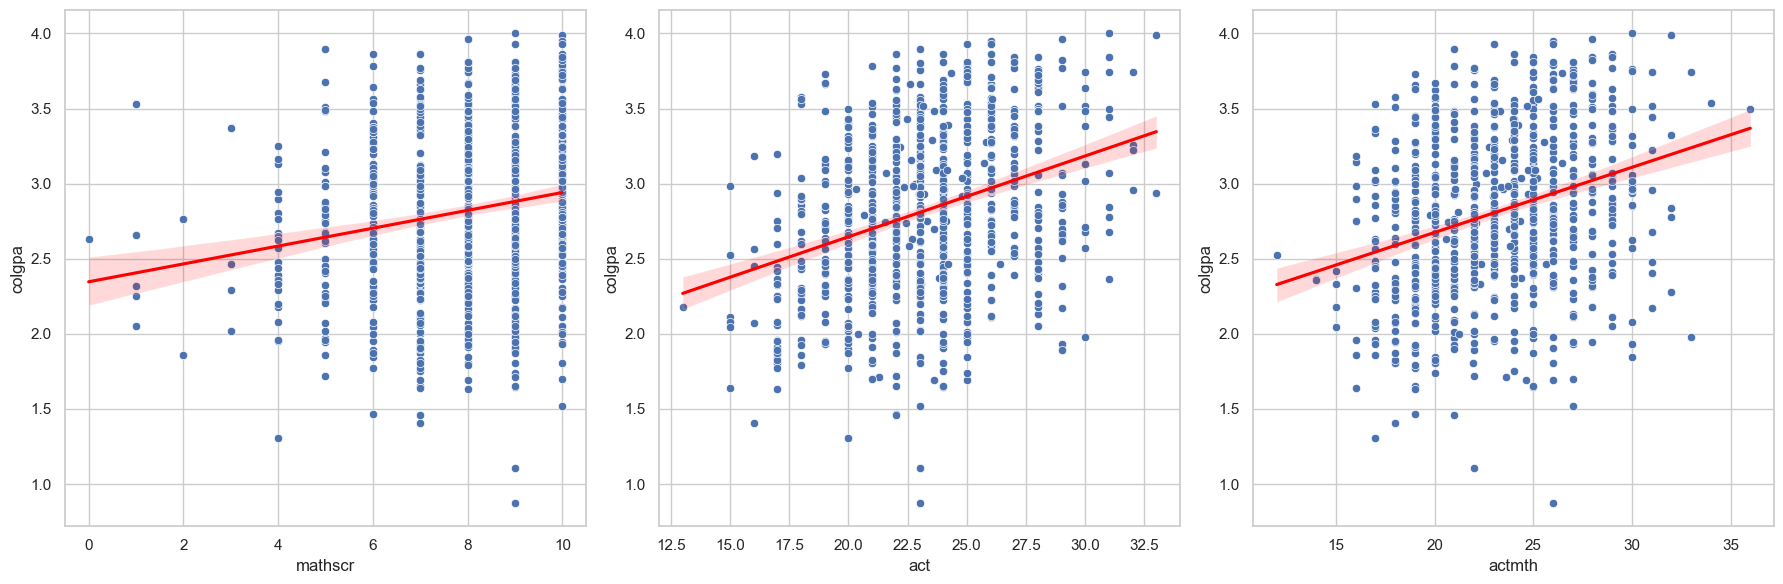

In [314]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.scatterplot(ax=axes[0], x='mathscr', y='colgpa', data=econmath_new)
sns.regplot(ax=axes[0], x='mathscr', y='colgpa', data=econmath_new, scatter=False, color='red')
sns.scatterplot(ax=axes[1], x='act', y='colgpa', data=econmath_new)
sns.regplot(ax=axes[1], x='act', y='colgpa', data=econmath_new, scatter=False, color='red')
sns.scatterplot(ax=axes[2], x='actmth', y='colgpa', data=econmath_new)
sns.regplot(ax=axes[2], x='actmth', y='colgpa', data=econmath_new, scatter=False, color='red')
plt.tight_layout()
plt.show()

#### Mathscr vs. Colgpa: This graph shows the relationship between mathscr (math test scores) and colgpa (college GPA). It can be seen that as math test scores increase, college GPA also tends to increase.The trend line indicates a degree of positive correlation, but the relationship is not entirely linear, especially at higher math score ranges.

#### Act vs. Colgpa: In this graph, the relationship between act (ACT composite score) and colgpa is analyzed. While the trend line shows a positive correlation, the distribution of data points indicates that the increase in college GPA is not always linear with rising ACT scores. Some students with high ACT scores do not necessarily have very high GPAs.

#### Actmth vs. Colgpa: The last graph presents the relationship between actmth (ACT math scores) and colgpa. Here, too, there is a positive correlation, but the relationship is not completely linear. Particularly in the higher ACT math score ranges, the distribution of college GPAs shows certain variability.

#### In statistical modeling, addressing nonlinearity in data to reveal linear relationships between variables is crucial. This can be achieved through various data transformation methods, such as log transformation for positively skewed data, square root transformation for mildly positive skew, power transformations for negative skew, and the Box-Cox transformation, which automatically selects the best parameters. These methods help reduce data skewness and improve the linearity of relationships between variables.

#### Regression models that do not appropriately transform nonlinear variables may face multiple issues. The model may have poor fit due to its inability to accurately capture the nonlinear patterns in the data, affecting the accuracy of predictions. Moreover, incorrect model specification can lead to misleading statistical inferences, such as inaccurate significance tests of parameters. Therefore, choosing and applying the right data transformation methods is vital in statistical analysis.

### 2-d

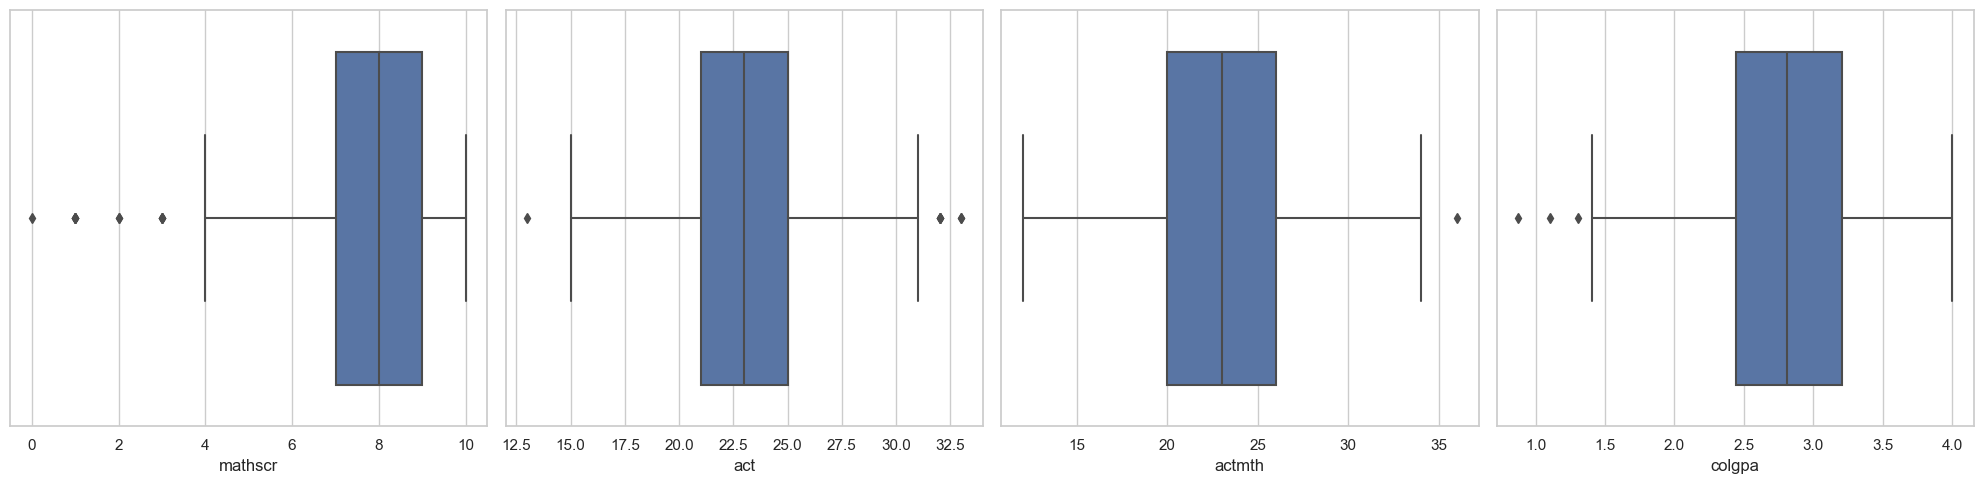

In [315]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
sns.boxplot(ax=axes[0], x=econmath_new['mathscr'])
sns.boxplot(ax=axes[1], x=econmath_new['act'])
sns.boxplot(ax=axes[2], x=econmath_new['actmth'])
sns.boxplot(ax=axes[3], x=econmath_new['colgpa'])
plt.tight_layout()
plt.show()

#### 1. \`mathscr\` (Math Test Scores): This variable seems to have no significant outliers. Scores are distributed between 0 to 10, aligning with its defined range.

#### 2. \`act\` (ACT Composite Score): The distribution of this variable appears relatively concentrated, with no apparent outliers.

#### 3. \`actmth\` (ACT Math Score): Similar to \`act\`, this variable also does not exhibit significant outliers.

#### 4. \`colgpa\` (College GPA): The distribution of this variable shows some potential low-end outliers.
#### These low GPA scores may require further investigation to determine whether they are data entry errors, measurement inaccuracies, or genuine and meaningful observations.

#### For low-end outliers in \`colgpa\`, if they are authentic and relevant to the study's objective, they should be retained. For instance, understanding why some students have extremely low GPAs could be important in a study of academic performance.
#### If these low GPA values are due to data entry errors, they should be corrected or removed to prevent skewing the overall analysis.
#### If deciding to retain these outliers, it's crucial to be aware that they may significantly influence the results in statistical methods like regression analysis. In such cases, the use of more robust statistical techniques could be considered.

### 2-e

### We have done this part in q1, and we adopt kNN methods.

## 3. Model Building:

## Model 1

In [171]:
mod = smf.ols(formula='score ~ mathscr+act+actmth+colgpa+male+calculus+attexc+mothcoll', data=econmath_new)
fit = mod.fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     73.97
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           3.24e-92
Time:                        20:08:19   Log-Likelihood:                -3208.9
No. Observations:                 856   AIC:                             6436.
Df Residuals:                     847   BIC:                             6479.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.8423      2.884      4.800      0.0

### 1-1 Multicollinearity: VIF

In [172]:
%%R
mreg.mod1=lm(score ~ mathscr+act+actmth+colgpa+male+calculus+attexc+mothcoll, data=econmath)
tidy(vif(mreg.mod1))

# A tibble: 8 × 2
  names        x
  <chr>    <dbl>
1 mathscr   1.36
2 act       2.30
3 actmth    2.57
4 colgpa    1.26
5 male      1.06
6 calculus  1.21
7 attexc    1.11
8 mothcoll  1.04


In addition: Warning message:
tidy.numeric不再有用。
见help("Deprecated") 


#### We don't need to worry about multicolinearity in this linear model.

### 1-2 Residual Plots

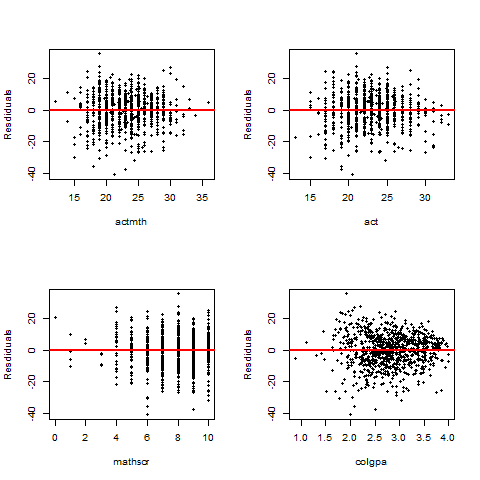

In [173]:
%%R
par(mfrow=c(2,2))
plot(econmath$actmth, mreg.mod1$residuals, pch=20,ylab="Resdiduals", xlab="actmth")
abline(h=0,col="red", lwd=2)

plot(econmath$act, mreg.mod1$residuals, pch=20,ylab="Resdiduals", xlab="act")
abline(h=0,col="red", lwd=2)

plot(econmath$mathscr, mreg.mod1$residuals, pch=20,ylab="Resdiduals", xlab="mathscr")
abline(h=0,col="red", lwd=2)

plot(econmath$colgpa, mreg.mod1$residuals, pch=20,ylab="Resdiduals", xlab="colgpa")
abline(h=0,col="red", lwd=2)

### 1-3 Model misspecification

In [177]:
%%R
resettest(mreg.mod1 , power=2, type="regressor")


	RESET test

data:  mreg.mod1
RESET = 3.5647, df1 = 8, df2 = 839, p-value = 0.0004477



#### According to the result, we may need interaction terms or a quadratic terms. We will talk about this later.

### 1-4 Heteroskedasticity

In [178]:
model_1 = smf.ols(formula = 'score~ mathscr + act  + actmth + colgpa + calculus + attexc + mothcoll +male', data = econmath_new).fit()

In [179]:
import statsmodels.stats.api as sms
from simple_colors import *
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(model_1.resid, model_1.model.exog)
print(blue("BP Results:",['bold']))
print(list(zip(name, test)))

BP Results:
[('Lagrange multiplier statistic', 56.4555730681649), ('p-value', 2.2994382367931247e-09), ('f-value', 7.475799464363653), ('f p-value', 1.1523449596942953e-09)]


#### We can see that we reject the null H0: variance = constant。
#### There exists problem of Heteroskedasticity.

### 1-5 Compare the traditional SE vs. the  White SE

In [181]:
reg_mod = smf.ols(formula='score ~ act+actmth+colgpa+male+calculus', data=econmath_new)

# estimate default model (only for spring data):
results_default = reg_mod.fit()

table_default = pd.DataFrame({'b': round(results_default.params, 5),
                              'se': round(results_default.bse, 5),
                              't': round(results_default.tvalues, 5),
                              'pval': round(results_default.pvalues, 5)})
print(f'Default Estimatws & Std. Errors: \n{table_default}\n')

# estimate model with White SE (only for spring data):
results_white = reg_mod.fit(cov_type='HC1')

table_white = pd.DataFrame({'b': round(results_white.params, 5),
                            'se': round(results_white.bse, 5),
                            't': round(results_white.tvalues, 5),
                            'pval': round(results_white.pvalues, 5)})
print(f'White Estimaets & Std. Errors: \n{table_white}\n')

Default Estimatws & Std. Errors: 
                  b       se         t     pval
Intercept  14.27269  2.80591   5.08665  0.00000
act         0.41029  0.15884   2.58305  0.00996
actmth      0.45521  0.14673   3.10231  0.00198
colgpa     12.36634  0.70492  17.54293  0.00000
male        2.55293  0.72460   3.52322  0.00045
calculus    3.22655  0.81093   3.97884  0.00008

White Estimaets & Std. Errors: 
                  b       se         t     pval
Intercept  14.27269  3.17161   4.50013  0.00001
act         0.41029  0.15930   2.57560  0.01001
actmth      0.45521  0.14215   3.20226  0.00136
colgpa     12.36634  0.74910  16.50826  0.00000
male        2.55293  0.72372   3.52751  0.00042
calculus    3.22655  0.82110   3.92952  0.00009



### 1-6 Feasible Generalized Least-Squares (unknown form of the variance)

In [186]:
# estimate model:
results_ols= reg_mod.fit()

# FGLS (estimation of the variance function):
econmath_new['logu2'] = np.log(results_ols.resid ** 2)
reg_fgls = smf.ols(formula='logu2 ~ act+actmth+colgpa+male+calculus+mathscr+mothcoll+attexc', data=econmath_new)
results_fgls = reg_fgls.fit()
table_fgls = pd.DataFrame({'b': round(results_fgls.params, 4),
                           'se': round(results_fgls.bse, 4),
                           't': round(results_fgls.tvalues, 4),
                           'pval': round(results_fgls.pvalues, 4)})
print(f'FGLS (Variance Function): \n{table_fgls}\n')

# FGLS (WLS):
wls_weight = list(1 / np.exp(results_fgls.fittedvalues))
reg_wls = smf.wls(formula='score~ mathscr + act  + actmth + colgpa + calculus + attexc + mothcoll +male',
                  weights=wls_weight, data=econmath_new)
results_wls = reg_wls.fit()
table_wls = pd.DataFrame({'b': round(results_wls.params, 4),
                          'se': round(results_wls.bse, 4),
                          't': round(results_wls.tvalues, 4),
                          'pval': round(results_wls.pvalues, 4)})
print(f'FGLS Estimates: \n{table_wls}\n')

FGLS (Variance Function): 
                b      se        t    pval
Intercept  6.5169  0.6009  10.8460  0.0000
act       -0.0472  0.0340  -1.3867  0.1659
actmth    -0.0124  0.0319  -0.3878  0.6982
colgpa    -0.5771  0.1540  -3.7483  0.0002
male      -0.0072  0.1513  -0.0479  0.9618
calculus   0.2483  0.1729   1.4354  0.1515
mathscr   -0.0387  0.0496  -0.7805  0.4353
mothcoll  -0.0437  0.1549  -0.2823  0.7778
attexc     0.0096  0.1700   0.0566  0.9548

FGLS Estimates: 
                 b      se        t    pval
Intercept  17.3948  2.8202   6.1678  0.0000
mathscr     0.0852  0.2360   0.3612  0.7181
act         0.2209  0.1505   1.4675  0.1426
actmth      0.4680  0.1425   3.2843  0.0011
colgpa     12.4350  0.7108  17.4953  0.0000
calculus    2.9114  0.7525   3.8687  0.0001
attexc      1.0829  0.7479   1.4480  0.1480
mothcoll   -0.2647  0.7035  -0.3762  0.7069
male        2.9808  0.6729   4.4296  0.0000



### 1-7 Test for interaction terms

### We have know from the RESET test that we need to include interaction terms or quadratic terms in our model. We have included a quadratic term in our model, the next step is to look whether there is an interaction term in the model.

### Among the 5 significant variables, 'act' is in quadratic form. Therefore, we tried to find possible interaction terms in six combinations of the other four variables.
### After trying all combinations, two interaction terms were significant, male*colgpa and male*calculus.

In [330]:
# Feasible Generalized Least-Squares (unknown form of the variance)
results_ols= mod.fit()
df = econmath_new
# FGLS (estimation of the variance function):
df['logu2'] = np.log(results_ols.resid ** 2)
reg_fgls = smf.ols(formula='logu2 ~ mathscr + act+actmth+colgpa+male+calculus', data=df)
results_fgls = reg_fgls.fit()
table_fgls = pd.DataFrame({'b': round(results_fgls.params, 4),
                           'se': round(results_fgls.bse, 4),
                           't': round(results_fgls.tvalues, 4),
                           'pval': round(results_fgls.pvalues, 4)})
print(f'FGLS (Variance Function): \n{table_fgls}\n')

# FGLS (WLS):
wls_weight = list(1 / np.exp(results_fgls.fittedvalues))
reg_wls = smf.wls(formula='score~ mathscr + act +  actmth + colgpa + mothcoll+ male*colgpa + calculus + male*calculus + male',
                  weights=wls_weight, data=df)
results_wls = reg_wls.fit()
table_wls = pd.DataFrame({'b': round(results_wls.params, 4),
                          'se': round(results_wls.bse, 4),
                          't': round(results_wls.tvalues, 4),
                          'pval': round(results_wls.pvalues, 4)})
print(f'FGLS Estimates: \n{table_wls}\n')

FGLS (Variance Function): 
                b      se        t    pval
Intercept  6.6255  0.5705  11.6136  0.0000
mathscr   -0.0657  0.0471  -1.3937  0.1638
act       -0.0311  0.0315  -0.9849  0.3250
actmth    -0.0133  0.0303  -0.4385  0.6611
colgpa    -0.6353  0.1401  -4.5337  0.0000
male      -0.0596  0.1438  -0.4140  0.6790
calculus   0.1565  0.1646   0.9509  0.3419

FGLS Estimates: 
                     b      se        t    pval
Intercept      20.3147  3.4343   5.9152  0.0000
mathscr         0.0913  0.2401   0.3804  0.7038
act             0.2009  0.1459   1.3768  0.1689
actmth          0.4648  0.1404   3.3097  0.0010
colgpa         11.3822  0.9555  11.9123  0.0000
mothcoll       -0.1941  0.6925  -0.2803  0.7793
male           -2.2553  3.9572  -0.5699  0.5689
male:colgpa     2.5207  1.2712   1.9829  0.0477
calculus        4.6796  1.0099   4.6337  0.0000
male:calculus  -3.4496  1.4336  -2.4062  0.0163



#### male:colgpa and male:calculus are statistically significant interaction terms so we should include them in the model!

### 1-8 Delete two large p-value variables to improve our model

#### a: AIC & BIC

In [258]:
# Feasible Generalized Least-Squares (unknown form of the variance)
results_ols= mod.fit()

# FGLS (estimation of the variance function):
econmath_new['logu2'] = np.log(results_ols.resid ** 2)
reg_fgls = smf.ols(formula='logu2 ~  mathscr + mothcoll+act + actmth + colgpa + calculus + attexc +male', data=econmath_new)
results_fgls = reg_fgls.fit()
table_fgls = pd.DataFrame({'b': round(results_fgls.params, 4),
                           'se': round(results_fgls.bse, 4),
                           't': round(results_fgls.tvalues, 4),
                           'pval': round(results_fgls.pvalues, 4)})
# FGLS (WLS):
wls_weight = list(1 / np.exp(results_fgls.fittedvalues))
reg_wls = smf.wls(formula='score~  act + mathscr + mothcoll + actmth + colgpa + calculus + attexc + male +male*colgpa  + male*calculus',
                  weights=wls_weight, data=econmath_new)
results1_wls = reg_wls.fit()
results1_wls.aic

6371.329307981402

In [262]:
results1_wls.bic

6423.604282118961

In [263]:
# Feasible Generalized Least-Squares (unknown form of the variance)
results_ols= mod.fit()

# FGLS (estimation of the variance function):
econmath_new['logu2'] = np.log(results_ols.resid ** 2)
reg_fgls = smf.ols(formula='logu2 ~  act + actmth + colgpa + calculus + attexc +male', data=econmath_new)
results_fgls = reg_fgls.fit()
table_fgls = pd.DataFrame({'b': round(results_fgls.params, 4),
                           'se': round(results_fgls.bse, 4),
                           't': round(results_fgls.tvalues, 4),
                           'pval': round(results_fgls.pvalues, 4)})
# FGLS (WLS):
wls_weight = list(1 / np.exp(results_fgls.fittedvalues))
reg_wls = smf.wls(formula='score~  act  + actmth + colgpa + calculus + attexc + male +male*colgpa  + male*calculus',
                  weights=wls_weight, data=econmath_new)
results2_wls = reg_wls.fit()
results2_wls.aic

6362.375665385633

In [264]:
results2_wls.bic

6405.146098770908

#### b: R-squared

In [265]:
results1_wls.rsquared

0.43481088674689194

In [267]:
results2_wls.rsquared

0.437525195774192

#### c: Cross validation

In [283]:
%%R
library(car)
library(lmvar)
ols.mod = lm(score~  mathscr+ mothcoll+act + colgpa + actmth + calculus + attexc + male + male*colgpa  + male*calculus, data = econmath)
ehatsq <- resid(ols.mod)**2
sighatsq.ols <- lm(log(ehatsq)~ mathscr+ mothcoll+act+colgpa+actmth+calculus+attexc+male, data=econmath)
vari <- exp(fitted(sighatsq.ols))
fgls.mod1 <- lm(score~   mathscr+ mothcoll+act + colgpa + actmth + calculus + attexc + male + male*colgpa  + male*calculus, weights=1/vari, x=TRUE,y=TRUE,data=econmath)
fit <- fgls.mod
cv.lm(fit, k = 5)

Mean absolute error        :  8.117906 
Sample standard deviation  :  0.5053615 

Mean squared error         :  108.374 
Sample standard deviation  :  17.01236 

Root mean squared error    :  10.38477 
Sample standard deviation  :  0.814452 



In [296]:
%%R
library(car)
library(lmvar)
ols.mod = lm(score~ act + colgpa + actmth + calculus + attexc + male + male*colgpa  + male*calculus, data = econmath)
ehatsq <- resid(ols.mod)**2
sighatsq.ols <- lm(log(ehatsq)~ act+colgpa+actmth+calculus+attexc+male, data=econmath)
vari <- exp(fitted(sighatsq.ols))
fgls.mod2 <- lm(score~   act + colgpa + actmth + calculus + attexc + male + male*colgpa  + male*calculus, weights=1/vari, x=TRUE,y=TRUE,data=econmath)
fit <- fgls.mod
cv.lm(fit, k = 5)

Mean absolute error        :  8.103907 
Sample standard deviation  :  0.2104007 

Mean squared error         :  107.617 
Sample standard deviation  :  4.245481 

Root mean squared error    :  10.37226 
Sample standard deviation  :  0.2037517 



#### Based on AIC, BIC, R^2 and RMSE, we should delete mathscr and mothcoll from the model.

### 1-9 Polynomial(Component-Plus-Residual Plot)

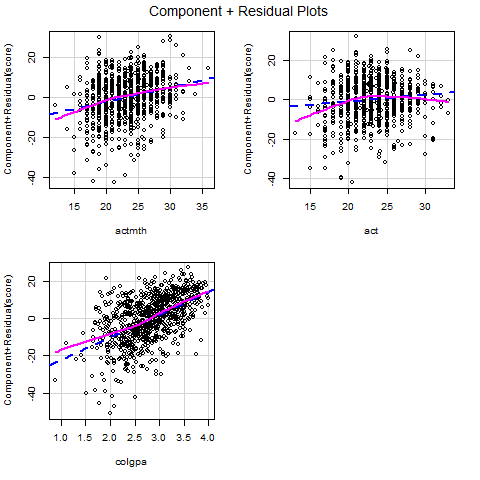

In [202]:
%%R
library(car)
econmath <- knnOutput
mreg.mod <- lm(score ~  actmth + act+ colgpa, data= econmath)
crPlots(mreg.mod, order=2)

#### Maybe mathscor, adctmth, colgpa has linear relationship with scores, but act needs to be transformed.

### Model 2: Transform act to poly(act,2)

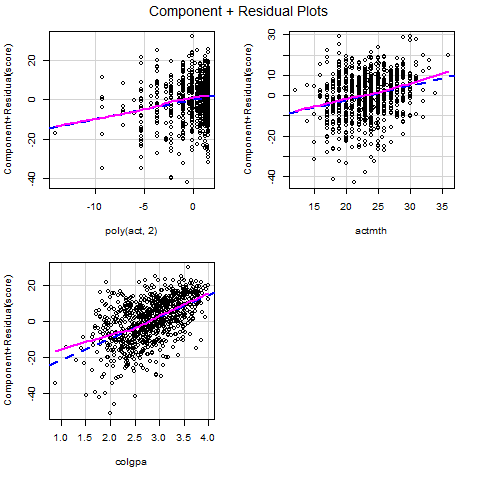

In [203]:
%%R
mreg.mod <- lm(score ~ poly(act,2) + actmth+ colgpa, data= econmath)
crPlots(mreg.mod, order=1)

#### From the plot of act, poly(act,2) can be an better alternative form of act.

### 2-1 Model regression

In [209]:
model_2 = smf.ols(formula = 'score~  act + I(act**2) + actmth + colgpa + calculus + attexc + male + male*colgpa  + male*calculus', data = econmath_new).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     70.73
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           6.17e-97
Time:                        21:05:12   Log-Likelihood:                -3195.6
No. Observations:                 856   AIC:                             6411.
Df Residuals:                     846   BIC:                             6459.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -42.2546     12.712     -3.324      0.001     -67.205     -17.305
act               5.6139      1.101      5.097      0.000       3.452       7.776
I(act ** 2)      -0.1101      0.023     -4.736      0.000      -0.156      -0.064
actmth            0.4473      0.145      3.083      0.002       0.163       0.732
colgpa           10.7896      0.999     10.800      0.000       8.829      12.750
calculus          4.3414      1.063      4.085      0.000       2.256       6.427
attexc            0.8979      0.805      1.116      0.265      -0.682       2.478
male             -1.2139      3.808     -0.319      0.750      -8.688       6.260
male:colgpa       1.9808      1.322      1.498      0.135      -0.615       4.576
male:calculus    -2.6495      1.534     -1.727      0.085      -5.660       0.361
==============================================================================
Omnibus:                       26.589   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.450
Skew:                          -0.349   Prob(JB):                     8.98e-08
Kurtosis:                       3.649   Cond. No.                     2.08e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.08e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### An interesting finding is that we find act has a quadratic trend in this model since I(act**2) and act is both statistically significant. We will study this result further in later parts.

### 2-2 Residual plots

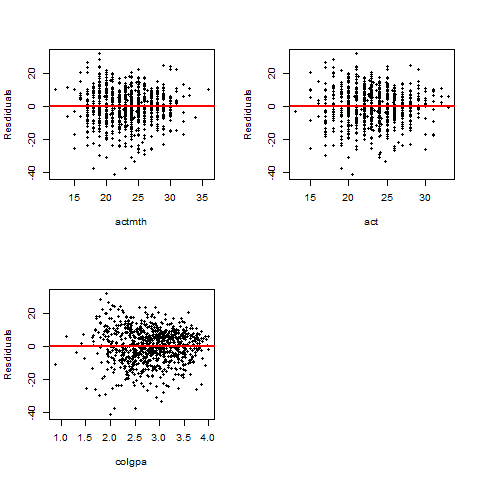

In [210]:
%%R
par(mfrow=c(2,2))
plot(econmath$actmth, mreg.mod$residuals, pch=20,ylab="Resdiduals", xlab="actmth")
abline(h=0,col="red", lwd=2)

plot(econmath$act, mreg.mod$residuals, pch=20,ylab="Resdiduals", xlab="act")
abline(h=0,col="red", lwd=2)


plot(econmath$colgpa, mreg.mod$residuals, pch=20,ylab="Resdiduals", xlab="colgpa")
abline(h=0,col="red", lwd=2)

### 2-3 QQ plot

 48 631 652 
 49 632 653 


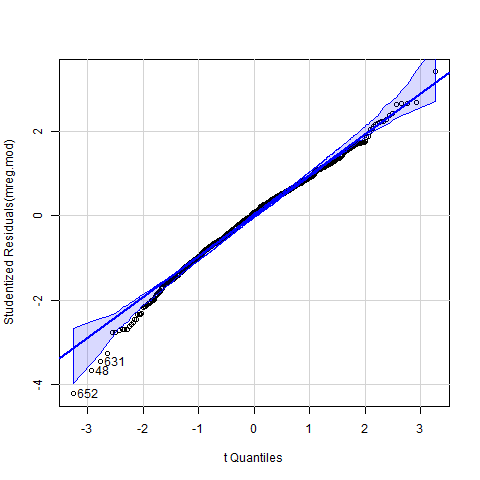

In [211]:
%%R
library(car)
mreg.mod <- lm(score ~  poly(act,2) + actmth+ colgpa + calculus + attexc +male +male*colgpa  + male*calculus, data= econmath)
qqPlot(mreg.mod, id=list(n=3))

In [212]:
%%R
outlierTest(mreg.mod)

     rstudent unadjusted p-value Bonferroni p
652 -4.226007         2.6376e-05     0.022578


### 2-4 Cook's distance

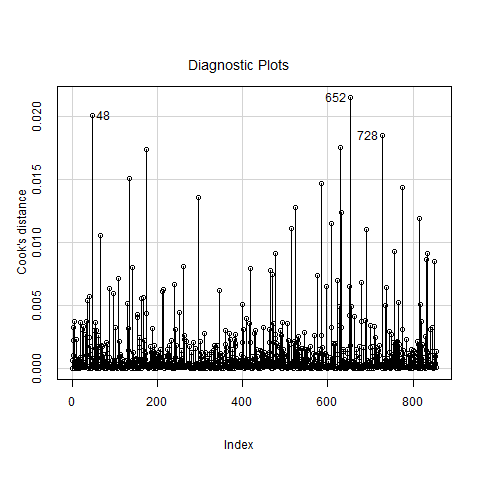

In [213]:
%%R
influenceIndexPlot(mreg.mod, id=list(n=3),vars="Cook")

### 2-5 Multicollinearity:GVIF

In [214]:
%%R
library(car)
mreg.mod = lm(score~  poly(act,2) + colgpa + actmth + calculus + attexc + male+male*colgpa  + male*calculus, data = econmath)
## We choose GVIF to deal with poly(act,2)
gvif_values <- vif(mreg.mod, exoByGroup = TRUE)
print(gvif_values)

                   GVIF Df GVIF^(1/(2*Df))
poly(act, 2)   2.305964  2        1.232291
colgpa         2.375015  1        1.541108
actmth         2.375052  1        1.541121
calculus       2.042928  1        1.429310
attexc         1.117501  1        1.057119
male          29.961364  1        5.473697
colgpa:male   29.936637  1        5.471438
calculus:male  4.547172  1        2.132410


there are higher-order terms (interactions) in this model
consider setting type = 'predictor'; see ?vif


#### Since we have poly(act,2) in model, we choose GVIF method (exoByGroup = TRUE) to measure multicollinearity.
#### The results are all below 4(we see the interaction terms as a whole) so we can say that there doesn't exist multicollinearity problems in this model.

### 2-6 Heteroskedasticity

In [215]:
import statsmodels.stats.api as sms
from simple_colors import *
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(model_2.resid, model_2.model.exog)
print(blue("BP Results:",['bold']))
print(list(zip(name, test)))

BP Results:
[('Lagrange multiplier statistic', 57.866395432245575), ('p-value', 3.4478690278695083e-09), ('f-value', 6.815201288983349), ('f p-value', 1.7045425331075566e-09)]


#### We can see that we reject the null H0: variance = constant。
#### There exists problem of Heteroskedasticity.

###  2-7 Compare the traditional SE vs. the  White SE

In [217]:
mod = smf.ols(formula = 'score~ act + I(act**2) + actmth + colgpa + calculus + attexc +male + +male*colgpa  + mal*calculus', data = econmath_new)
# estimate default model (only for spring data):
results_default = mod.fit()

table_default = pd.DataFrame({'b': round(results_default.params, 5),
                              'se': round(results_default.bse, 5),
                              't': round(results_default.tvalues, 5),
                              'pval': round(results_default.pvalues, 5)})
print(f'Default Estimatws & Std. Errors: \n{table_default}\n')

# estimate model with White SE (only for spring data):
results_white = mod.fit(cov_type='HC1')

table_white = pd.DataFrame({'b': round(results_white.params, 5),
                            'se': round(results_white.bse, 5),
                            't': round(results_white.tvalues, 5),
                            'pval': round(results_white.pvalues, 5)})
print(f'White Estimaets & Std. Errors: \n{table_white}\n')

Default Estimatws & Std. Errors: 
                      b        se         t     pval
Intercept     -42.25458  12.71162  -3.32409  0.00093
act             5.61389   1.10132   5.09742  0.00000
I(act ** 2)    -0.11014   0.02326  -4.73590  0.00000
actmth          0.44730   0.14508   3.08306  0.00212
colgpa         10.78959   0.99904  10.79995  0.00000
calculus        4.34136   1.06263   4.08547  0.00005
attexc          0.89792   0.80491   1.11556  0.26493
male           -1.21393   3.80780  -0.31880  0.74996
male:colgpa     1.98081   1.32241   1.49788  0.13454
male:calculus  -2.64946   1.53400  -1.72716  0.08450

White Estimaets & Std. Errors: 
                      b        se        t     pval
Intercept     -42.25458  13.81411 -3.05880  0.00222
act             5.61389   1.14345  4.90962  0.00000
I(act ** 2)    -0.11014   0.02380 -4.62769  0.00000
actmth          0.44730   0.14035  3.18704  0.00144
colgpa         10.78959   1.09362  9.86593  0.00000
calculus        4.34136   1.12289  3.8

### 2-8 FGLS

In [326]:
# Feasible Generalized Least-Squares (unknown form of the variance)
results_ols= mod.fit()

# FGLS (estimation of the variance function):
econmath_new['logu2'] = np.log(results_ols.resid ** 2)
reg_fgls = smf.ols(formula='logu2 ~  act + actmth + colgpa + calculus + attexc +male', data=econmath_new)
results_fgls = reg_fgls.fit()
table_fgls = pd.DataFrame({'b': round(results_fgls.params, 4),
                           'se': round(results_fgls.bse, 4),
                           't': round(results_fgls.tvalues, 4),
                           'pval': round(results_fgls.pvalues, 4)})
print(f'FGLS (Variance Function): \n{table_fgls}\n')

# FGLS (WLS):
wls_weight = list(1 / np.exp(results_fgls.fittedvalues))
reg_wls = smf.wls(formula='score~  act + I(act**2) + actmth + colgpa + calculus + attexc + male +male*colgpa  + male*calculus',
                  weights=wls_weight, data=econmath_new)
results_wls = reg_wls.fit()
table_wls = pd.DataFrame({'b': round(results_wls.params, 4),
                          'se': round(results_wls.bse, 4),
                          't': round(results_wls.tvalues, 4),
                          'pval': round(results_wls.pvalues, 4)})
print(f'FGLS Estimates: \n{table_wls}\n')

FGLS (Variance Function): 
                b      se        t    pval
Intercept  6.4760  0.5588  11.5883  0.0000
act       -0.0353  0.0323  -1.0941  0.2742
actmth    -0.0239  0.0292  -0.8195  0.4127
colgpa    -0.6222  0.1458  -4.2685  0.0000
calculus   0.1098  0.1611   0.6814  0.4958
attexc    -0.0945  0.1618  -0.5841  0.5593
male      -0.0594  0.1440  -0.4123  0.6802

FGLS Estimates: 
                     b       se        t    pval
Intercept     -29.8177  12.7727  -2.3345  0.0198
act             4.4668   1.0605   4.2120  0.0000
I(act ** 2)    -0.0873   0.0215  -4.0498  0.0001
actmth          0.4949   0.1333   3.7123  0.0002
colgpa         10.8748   0.9586  11.3447  0.0000
calculus        4.6340   0.9901   4.6805  0.0000
attexc          1.2684   0.7190   1.7642  0.0781
male           -2.4584   3.8996  -0.6304  0.5286
male:colgpa     2.6422   1.2537   2.1075  0.0354
male:calculus  -3.6857   1.4126  -2.6092  0.0092



In [322]:
print(results_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.448
Model:                            WLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     76.36
Date:                Tue, 21 Nov 2023   Prob (F-statistic):          4.85e-103
Time:                        23:24:28   Log-Likelihood:                -3164.0
No. Observations:                 856   AIC:                             6348.
Df Residuals:                     846   BIC:                             6395.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -29.8177     12.773     -2.334

#### FGLS improves the model since the stanard error and p-values of all parameters changed better.
#### attexc's pvalue is 0.1155 and this adjusted parameter means it is not far from statistical significance.

### 2-9 Consider whether to delete attexc(p_value=0.07)

#### AIC & BIC

In [238]:
# Feasible Generalized Least-Squares (unknown form of the variance)
results_ols= mod.fit()

# FGLS (estimation of the variance function):
econmath_new['logu2'] = np.log(results_ols.resid ** 2)
reg_fgls = smf.ols(formula='logu2 ~  act + actmth + colgpa + calculus + attexc +male', data=econmath_new)
results_fgls = reg_fgls.fit()
table_fgls = pd.DataFrame({'b': round(results_fgls.params, 4),
                           'se': round(results_fgls.bse, 4),
                           't': round(results_fgls.tvalues, 4),
                           'pval': round(results_fgls.pvalues, 4)})
# FGLS (WLS):
wls_weight = list(1 / np.exp(results_fgls.fittedvalues))
reg_wls = smf.wls(formula='score~  act + I(act**2) + actmth + colgpa + calculus + attexc + male +male*colgpa  + male*calculus',
                  weights=wls_weight, data=econmath_new)
results3_wls = reg_wls.fit()
results3_wls.aic

6347.93950755645

In [239]:
results3_wls.bic

6395.4622113178675

In [240]:
# Feasible Generalized Least-Squares (unknown form of the variance)
results_ols= mod.fit()

# FGLS (estimation of the variance function):
econmath_new['logu2'] = np.log(results_ols.resid ** 2)
reg_fgls = smf.ols(formula='logu2 ~  act + actmth + colgpa + calculus + male', data=econmath_new)
results_fgls = reg_fgls.fit()
table_fgls = pd.DataFrame({'b': round(results_fgls.params, 4),
                           'se': round(results_fgls.bse, 4),
                           't': round(results_fgls.tvalues, 4),
                           'pval': round(results_fgls.pvalues, 4)})
# FGLS (WLS):
wls_weight = list(1 / np.exp(results_fgls.fittedvalues))
reg_wls = smf.wls(formula='score~  act + I(act**2) + actmth + colgpa + calculus +  male +male*colgpa  + male*calculus',
                  weights=wls_weight, data=econmath_new)
results4_wls = reg_wls.fit()
results4_wls.aic

6350.718838065143

In [241]:
results4_wls.bic

6393.4892714504185

#### R-squared

In [243]:
results3_wls.rsquared

0.44822231442610694

In [244]:
results4_wls.rsquared

0.4430953608414725

#### Cross validation

In [256]:
%%R
library(car)
library(lmvar)
ols.mod = lm(score~  poly(act,2) + colgpa + actmth + calculus + attexc + male + male*colgpa  + male*calculus, data = econmath)
ehatsq <- resid(ols.mod)**2
sighatsq.ols <- lm(log(ehatsq)~act+colgpa+actmth+calculus+attexc+male, data=econmath)
vari <- exp(fitted(sighatsq.ols))
fgls.mod <- lm(score~  poly(act,2) + colgpa + actmth + calculus + attexc + male + male*colgpa  + male*calculus, weights=1/vari, x=TRUE,y=TRUE,data=econmath)
fit <- fgls.mod
cv.lm(fit, k = 5)

Mean absolute error        :  8.052506 
Sample standard deviation  :  0.3436675 

Mean squared error         :  104.9956 
Sample standard deviation  :  11.55471 

Root mean squared error    :  10.23512 
Sample standard deviation  :  0.5453898 



In [257]:
%%R
library(car)
library(lmvar)
ols.mod = lm(score~  poly(act,2) + colgpa + actmth + calculus +  male + male*colgpa  + male*calculus, data = econmath)
ehatsq <- resid(ols.mod)**2
sighatsq.ols <- lm(log(ehatsq)~act+colgpa+actmth+calculus+male, data=econmath)
vari <- exp(fitted(sighatsq.ols))
fgls.mod <- lm(score~  poly(act,2) + colgpa + actmth + calculus +  male + male*colgpa  + male*calculus, weights=1/vari, x=TRUE,y=TRUE,data=econmath)
fit <- fgls.mod
cv.lm(fit, k = 5)

Mean absolute error        :  8.028326 
Sample standard deviation  :  0.7090194 

Mean squared error         :  104.7624 
Sample standard deviation  :  19.51923 

Root mean squared error    :  10.20257 
Sample standard deviation  :  0.9151513 



#### Based on AIC, BIC, R^2 and RMSE, we should include attexc in the model.

### 2-10 Boostrapping

In [297]:
%%R
library(boot)
library(car)
set.seed(3435)
ols.mod = lm(score~  poly(act,2) + colgpa + actmth + calculus + attexc + male + male*colgpa  + male*calculus, data = econmath)
ehatsq <- resid(ols.mod)**2
sighatsq.ols <- lm(log(ehatsq)~act+colgpa+actmth+calculus+attexc+male, data=econmath)
vari <- exp(fitted(sighatsq.ols))
fgls.mod <- lm(score~  poly(act,2) + colgpa + actmth + calculus + attexc + male + male*colgpa  + male*calculus, weights=1/vari, x=TRUE,y=TRUE,data=econmath)
betahat.boot = Boot(fgls.mod, R=999)
usualEsts = summary(fgls.mod)$coef[, 1:2]
summary(betahat.boot)


Number of bootstrap replications R = 999 
              original   bootBias   bootSE   bootMed
(Intercept)    25.8797  0.1925153  3.79133  26.01950
poly(act, 2)1  37.4473  0.5601863 14.63152  38.14467
poly(act, 2)2 -38.4047 -0.6743968 10.13806 -38.63954
colgpa         10.8748 -0.0117291  1.00428  10.93437
actmth          0.4949 -0.0063079  0.13188   0.48988
calculus        4.6340 -0.0051918  1.13465   4.61520
attexc          1.2684 -0.0014440  0.72262   1.27736
male           -2.4584  0.1177104  4.10397  -2.26667
colgpa:male     2.6422 -0.0404965  1.33912   2.56202
calculus:male  -3.6857  0.0014755  1.41939  -3.73299


In [303]:
%%R
confint(betahat.boot)

Bootstrap bca confidence intervals

                     2.5 %      97.5 %
(Intercept)    18.43823770  33.3058246
poly(act, 2)1   5.87428691  64.7433696
poly(act, 2)2 -59.95305680 -19.8971378
colgpa          8.49660349  12.5902115
actmth          0.24386716   0.7513955
calculus        2.46701299   6.8164311
attexc         -0.07734998   2.7113911
male          -10.71610657   5.0062832
colgpa:male     0.31068511   5.4657353
calculus:male  -6.41061059  -0.7597426


In [304]:
%%R
boot <- summary(betahat.boot)
ci <- confint(betahat.boot)

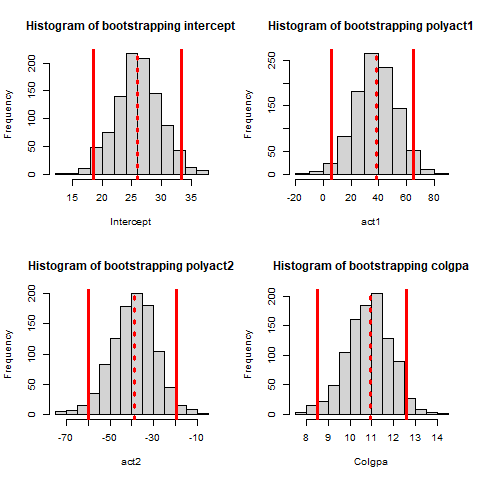

In [306]:
%%R
par(mfrow = c(2, 2))
hist(betahat.boot$t[,1],main = 'Histogram of bootstrapping intercept',xlab = 'Intercept')
abline(v = boot["(Intercept)","bootMed"], col = 'red',lwd=3,lty=3)
abline(v=ci["(Intercept)","97.5 %"], col='red',lwd=3,lty=1)
abline(v=ci["(Intercept)","2.5 %"], col='red',lwd=3,lty=1)


hist(betahat.boot$t[,2],main = 'Histogram of bootstrapping polyact1',xlab = 'act1')
abline(v = boot["poly(act, 2)1","bootMed"], col = 'red',lwd=3,lty=3)
abline(v=ci["poly(act, 2)1","97.5 %"], col='red',lwd=3,lty=1)
abline(v=ci["poly(act, 2)1","2.5 %"], col='red',lwd=3,lty=1)

hist(betahat.boot$t[,3],main = 'Histogram of bootstrapping polyact2',xlab = 'act2')
abline(v = boot["poly(act, 2)2","bootMed"], col = 'red',lwd=3,lty=3)
abline(v=ci["poly(act, 2)2","97.5 %"], col='red',lwd=3,lty=1)
abline(v=ci["poly(act, 2)2","2.5 %"], col='red',lwd=3,lty=1)

hist(betahat.boot$t[,4],main = 'Histogram of bootstrapping colgpa',xlab = 'Colgpa')
abline(v = boot["colgpa","bootMed"], col = 'red',lwd=3,lty=3)
abline(v=ci["colgpa","97.5 %"], col='red',lwd=3,lty=1)
abline(v=ci["colgpa","2.5 %"], col='red',lwd=3,lty=1)

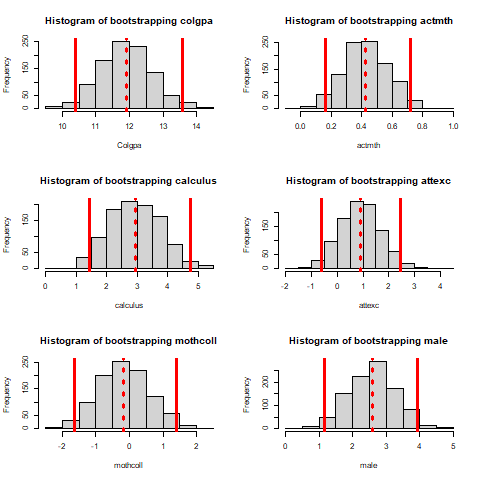

In [144]:
%%R
par(mfrow = c(3, 2))

hist(betahat.boot$t[,5],main = 'Histogram of bootstrapping actmth',xlab = 'actmth')
abline(v = boot["actmth","bootMed"], col = 'red',lwd=3,lty=3)
abline(v=ci["actmth","97.5 %"], col='red',lwd=3,lty=1)
abline(v=ci["actmth","2.5 %"], col='red',lwd=3,lty=1)

hist(betahat.boot$t[,6],main = 'Histogram of bootstrapping calculus',xlab = 'calculus')
abline(v = boot["calculus","bootMed"], col = 'red',lwd=3,lty=3)
abline(v=ci["calculus","97.5 %"], col='red',lwd=3,lty=1)
abline(v=ci["calculus","2.5 %"], col='red',lwd=3,lty=1)

hist(betahat.boot$t[,7],main = 'Histogram of bootstrapping attexc',xlab = 'attexc')
abline(v = boot["attexc","bootMed"], col = 'red',lwd=3,lty=3)
abline(v=ci["attexc","97.5 %"], col='red',lwd=3,lty=1)
abline(v=ci["attexc","2.5 %"], col='red',lwd=3,lty=1)


hist(betahat.boot$t[,8],main = 'Histogram of bootstrapping male',xlab = 'male')
abline(v = boot["male","bootMed"], col = 'red',lwd=3,lty=3)
abline(v=ci["male","97.5 %"], col='red',lwd=3,lty=1)
abline(v=ci["male","2.5 %"], col='red',lwd=3,lty=1)

hist(betahat.boot$t[,9],main = 'Histogram of bootstrapping colgpa:male',xlab = 'colgpa:male')
abline(v = boot["mothcoll","bootMed"], col = 'red',lwd=3,lty=3)
abline(v=ci["mothcoll","97.5 %"], col='red',lwd=3,lty=1)
abline(v=ci["mothcoll","2.5 %"], col='red',lwd=3,lty=1)

hist(betahat.boot$t[,10],main = 'Histogram of bootstrapping calculus:male ',xlab = 'calculus:male ')
abline(v = boot["mothcoll","bootMed"], col = 'red',lwd=3,lty=3)
abline(v=ci["mothcoll","97.5 %"], col='red',lwd=3,lty=1)
abline(v=ci["mothcoll","2.5 %"], col='red',lwd=3,lty=1)

#### The bootrapped results are not bad since the sign of every parameter is correct in confidence interval but for poly(act,2), the robustness of the parameters are not good implied from the BootSE 15 and 10.

### 2-11 Marginal Effects

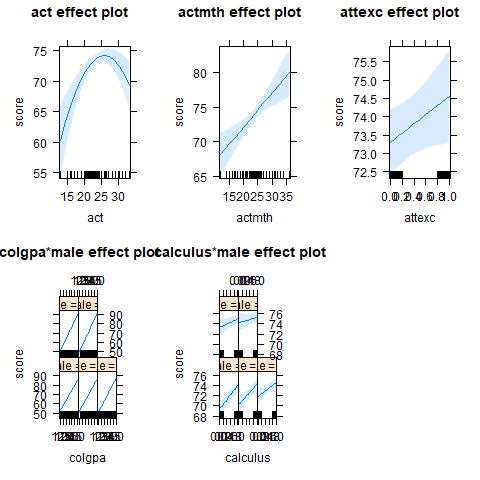

In [307]:
%%R
library(effects)
plot(allEffects(fgls.mod))

In [310]:
%%R
library("margins")
library(boot)
library(car)
ols.mod = lm(score~  poly(act,2) + colgpa + actmth + calculus + attexc + male + male*colgpa  + male*calculus, data = econmath)
ehatsq <- resid(ols.mod)**2
sighatsq.ols <- lm(log(ehatsq)~act+colgpa+actmth+calculus+attexc+male, data=econmath)
vari <- exp(fitted(sighatsq.ols))
fgls.mod <- lm(score~  act+ I(act**2) + colgpa + actmth + calculus + attexc + male + male*colgpa  + male*calculus, weights=1/vari,data=econmath)
m <- margins(fgls.mod)
summary(m)

   factor     AME     SE       z      p   lower   upper
      act  0.4303 0.1563  2.7532 0.0059  0.1240  0.7366
   actmth  0.4949 0.1333  3.7123 0.0002  0.2336  0.7562
   attexc  1.2684 0.7189  1.7643 0.0777 -0.1407  2.6775
 calculus  2.7911 0.7391  3.7765 0.0002  1.3426  4.2397
   colgpa 12.1959 0.7017 17.3805 0.0000 10.8206 13.5712
     male  2.4854 0.7096  3.5025 0.0005  1.0946  3.8763


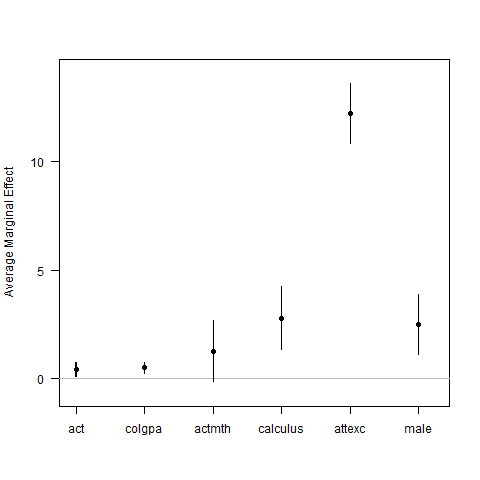

In [311]:
%%R
plot(m)

## Final Conclusion

In [331]:
# Feasible Generalized Least-Squares (unknown form of the variance)
results_ols= mod.fit()

# FGLS (estimation of the variance function):
df['logu2'] = np.log(results_ols.resid ** 2)
reg_fgls = smf.ols(formula='logu2 ~ act+actmth+colgpa+attexc+male+calculus', data=df)
results_fgls = reg_fgls.fit()
table_fgls = pd.DataFrame({'b': round(results_fgls.params, 4),
                           'se': round(results_fgls.bse, 4),
                           't': round(results_fgls.tvalues, 4),
                           'pval': round(results_fgls.pvalues, 4)})
print(f'FGLS (Variance Function): \n{table_fgls}\n')

# FGLS (WLS):
wls_weight = list(1 / np.exp(results_fgls.fittedvalues))
reg_wls = smf.wls(formula='score~ act + I(act**2) + actmth + colgpa + attexc + male*colgpa + calculus + male*calculus + male',
                  weights=wls_weight, data=df)
results_wls = reg_wls.fit()
table_wls = pd.DataFrame({'b': round(results_wls.params, 4),
                          'se': round(results_wls.bse, 4),
                          't': round(results_wls.tvalues, 4),
                          'pval': round(results_wls.pvalues, 4)})
print(f'FGLS Estimates: \n{table_wls}\n')

FGLS (Variance Function): 
                b      se        t    pval
Intercept  6.4760  0.5588  11.5883  0.0000
act       -0.0353  0.0323  -1.0941  0.2742
actmth    -0.0239  0.0292  -0.8195  0.4127
colgpa    -0.6222  0.1458  -4.2685  0.0000
attexc    -0.0945  0.1618  -0.5841  0.5593
male      -0.0594  0.1440  -0.4123  0.6802
calculus   0.1098  0.1611   0.6814  0.4958

FGLS Estimates: 
                     b       se        t    pval
Intercept     -29.8177  12.7727  -2.3345  0.0198
act             4.4668   1.0605   4.2120  0.0000
I(act ** 2)    -0.0873   0.0215  -4.0498  0.0001
actmth          0.4949   0.1333   3.7123  0.0002
colgpa         10.8748   0.9586  11.3447  0.0000
attexc          1.2684   0.7190   1.7642  0.0781
male           -2.4584   3.8996  -0.6304  0.5286
male:colgpa     2.6422   1.2537   2.1075  0.0354
calculus        4.6340   0.9901   4.6805  0.0000
male:calculus  -3.6857   1.4126  -2.6092  0.0092



### We can see from the table above that, remain everything else unchanged:
### For every 1 point increase in ACT math score, we expect the course score to increase by 0.4949.
### For every 1 point increase in college GPA of the beginning semester, we expect the course score of female students to increase by 10.8748, and the course score of male students to increase by 10.8748 + 2.6422 = 13.5170.
### For every 1 point increase in ACT total score, we expect the course score to increase by 4.4668+(-0.0873)act.

### For student whose past attndce is 'excellent', we expect their course score is 1.2684 higher than those who did not get 'excerllent'..

### Female students who have not learned calculus is the default group.
### For male students who have learned calculus, we expect their course score is -3.6857 + 2.6422*colgpa + 4.6340+ (--2.4584) = -1.5101 + 3.0517*colgpa higher than the default group.
### For male students who have not learned calculus, we expect their course score is -3.6857 + 2.6422*colgpa higher than the default group.
### For female students who have learned calculus, we expectM their course score is 4.6340 higher than the default group.

## Insights: The students who have higher ACT math score perform better in the econ-course exam, but the score of math quiz can not help us to predict students' course score. Given that math and econometrics are indeed very related, we can say that ACT math assess a student's math ability better than math quiz.
## Students who have higher gpa in the begining semester performs better in the course exam, and this is more obvious for male students. One possible reason is that GPA refelcts a student's learning ability and willingness.

## Basically, the more a student score in ACT, the more score he/she get in course exam, since ACT to some extent reflects a student's learning ability. However, if students' ACT score is too high, the score of course exam could be slightly lower. That could because students who get really high score in ACT have to spend a lot of time in subjects like English, Science, and Reading, their math ability could be weaker than those have a high ACT math score but a relatively lower ACT total score.

## As long as a student has learned calcuclus, he/she will perform better in course exam. Especally for the male students that have high GPA. Calculus does help student to learn econometrics.

## Female students can perform better in course exam than those low GPA male students, but male students that have high GPA can eliminate this effect, and get even higher score.